In [25]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
pd.options.mode.chained_assignment = None  
from scipy import optimize,interpolate
import sklearn 
from sklearn.cluster import DBSCAN
import scipy
from lmfit import Model
from mpl_point_clicker import clicker

In [26]:
%matplotlib widget

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.spatial.transform import Rotation
from sympy import Matrix, pi, pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class TNG50DataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.chunk_size = 102609 // 9
        self.load_data()

    def load_data(self):
        chunks = pd.read_csv(self.file_path, sep=',', names=['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho'], header=0, chunksize=self.chunk_size)
        self.accumulated_data = np.concatenate([chunk.values for chunk in chunks])

    def calculate_center_of_mass_new(self, value_energy=2.63):
        Log_energy = np.log10(self.accumulated_data[:, 10])
        avg_energy = np.mean(Log_energy)
        if value_energy == 1:
            value_energy = avg_energy
        energy_filter = Log_energy < value_energy
        self.filtered_data = self.accumulated_data[energy_filter]
        return np.sum(self.filtered_data[:, :3], axis=0) / len(self.accumulated_data)

    def calculate_total_angular_momentum(self):
        center_of_mass = self.calculate_center_of_mass_new()
        r_i = self.filtered_data[:, :3] - center_of_mass
        v_i = self.filtered_data[:, 3:6] - self.calculate_velocity_of_mass()
        return np.sum(np.cross(r_i, v_i), axis=0)

    def calculate_velocity_of_mass(self):
        return np.mean(self.filtered_data[:, 3:6], axis=0)

class RotationHandler:
    def __init__(self, direction):
      self.direction = direction
      direction = angular_direction[largest_component]
      pass

    def choose_rotation_matrix(self, largest_component, direction):
        if largest_component == 0:
            if direction == 1:
                matrix = Rotation.from_euler('y', -pi/2).as_matrix()
            elif direction == -1:
                matrix = Rotation.from_euler('y', pi/2).as_matrix()
        elif largest_component == 1:
            if direction == 1:
                matrix = Rotation.from_euler('x', pi/2).as_matrix()
            elif direction == -1:
                matrix = Rotation.from_euler('x', -pi/2).as_matrix()
        elif largest_component == 2:
            if direction == 1:
                matrix = np.identity(3)
            elif direction == -1:
                matrix = Rotation.from_euler('z', pi).as_matrix()
        return matrix

    def apply_rotation(self, matrix, vector):
        rotated_array = np.zeros_like(vector)
        if vector.size == 3:
            rotated_array = np.dot(matrix, vector)
        else:
            for i in range(vector.shape[0]):
                rotated_array[i, :] = np.dot(matrix, vector[i, :])
        return rotated_array

class VelocityEscapeCalculator:
    def __init__(self, data, potential):
        self.data = data
        self.potential = potential

    def calculate_magnitudes(self):
        velocity_magnitude = np.sqrt(np.sum(self.data[:, 3:6]**2, axis=1)).reshape(-1, 1)
        position_magnitude = np.sqrt(np.sum(self.data[:, :3]**2, axis=1)).reshape(-1, 1)
        self.data = np.concatenate([self.data, velocity_magnitude, position_magnitude], axis=1)

    def calculate_escape_velocity(self):
        escape_velocity = np.sqrt(2 * np.abs(self.potential)).reshape(-1, 1)
        self.data = np.concatenate([self.data, escape_velocity], axis=1)

    def get_processed_data(self):
        columns = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho', 'velocity_magnitude', 'position_magnitude', 'escape_velocity']
        return pd.DataFrame(self.data, columns=columns)

class VisualizationHandler:
    def visualize_galaxy_one(self, rotated_vectors_filtered, center_of_mass, ax, title):
        ax.scatter(rotated_vectors_filtered[:, 0], rotated_vectors_filtered[:, 1], s=0.003, alpha=0.5)
        ax.scatter(center_of_mass[0], center_of_mass[1], color='red', s=0.3, marker='x')
        ax.set_title(title)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(-18, 18)
        ax.set_ylim(-18, 18)
        ax.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.grid(True, alpha=0.4)


In [28]:
%matplotlib widget


In [29]:
id='198185'
simulation = TNG50DataProcessor(f"DATA/processed/halo_{id}_datos_dbscan_sf.csv")
data = simulation.accumulated_data
data

array([[ 4.38238526e-02,  3.42331270e-01, -1.04010190e-01, ...,
        -5.43000500e+05,  4.20998169e+02,  2.13500000e-03],
       [ 3.47527203e-02,  3.95997015e-01,  2.14947162e-02, ...,
        -5.42014688e+05,  4.13550140e+02,  2.57600000e-03],
       [-4.50497412e-01,  2.31561960e-01,  1.65757033e-01, ...,
        -5.37347750e+05,  2.80314392e+02,  1.35900000e-03],
       ...,
       [-3.22182895e+01,  1.55331565e+01, -2.58276002e+01, ...,
        -5.10075719e+05,  2.44616425e+02,  1.06100000e-03],
       [-3.20914222e+01,  1.54955483e+01, -2.55293625e+01, ...,
        -5.09706969e+05,  1.01196175e+02,  5.22000000e-04],
       [-3.19756510e+01,  1.55640416e+01, -2.55301615e+01, ...,
        -5.09667156e+05,  1.00825981e+02,  2.61000000e-04]])

# **Arm Tracing $\rho$**

In [30]:
# Crear un DataFrame con las columnas necesarias
df = pd.DataFrame(data, columns=['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho'])

# Convertir coordenadas a coordenadas galácticas (Rs y Zs) si es necesario
df['Rs'] = np.sqrt(df['x']**2 + df['y']**2)  # Ejemplo de cómo obtener Rs
df['Zs'] = df['z']

# Filtrar el disco galáctico, similar a lo que se hace en el notebook original
Initial_df_sorted = df.sort_values(by=['Rs'])

df_filtered = df[(np.abs(Initial_df_sorted['Zs']) <= 1.5) & (Initial_df_sorted['Rs'] > 1)]



Xs_i       = Initial_df_sorted['x']
Ys_i       = Initial_df_sorted['y']
Rs_i       = Initial_df_sorted['Rs']

rho_sph_i       = Initial_df_sorted['rho']

Xs_z       = df_filtered["x"]
Ys_z       = df_filtered["y"]
Rs_z       = df_filtered["Rs"]

rho_sph_z       = df_filtered["rho"]

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [31]:
Rs_mean  = []
rho_sph_mean = []
deltaR  = 0.1
step    = 0
while(step + deltaR < 20):
    a = np.mean(rho_sph_z[(Rs_z > step ) & (Rs_z < step + deltaR) ] )
    minBin = np.min(Rs_z[ (Rs_z > step ) & (Rs_z < step + deltaR) ] )    
    maxBin = np.max(Rs_z[ (Rs_z > step ) & (Rs_z < step + deltaR) ] ) 

    b = np.round( (maxBin + minBin)*0.5, 2)
    rho_sph_mean.append(a)
    Rs_mean.append(b)
    step = step + 0.1

    
Rs_mean = [x for x in Rs_mean if str(x) != 'nan']
rho_sph_mean = [x for x in rho_sph_mean if str(x) != 'nan']

In [32]:
x = np.array(Rs_mean)
y = np.array(rho_sph_mean)

ylog = np.array( np.log10(y) )

f = interpolate.interp1d(x, y, kind='cubic')

xnew = np.linspace( np.min(Rs_mean), np.max(Rs_mean), 2000)
xnew = np.array(xnew)
ynew = f(xnew)

Initial_df_lim = df_filtered.loc[(Initial_df_sorted.Rs > np.min(Rs_mean)) & (Initial_df_sorted.Rs < np.max(Rs_mean)) ]
Initial_df_lim['rho_sph_log']  = np.log10(Initial_df_lim.rho)

Rs_i_lim   = Initial_df_lim['Rs']
rho_sph_i_lim = Initial_df_lim['rho']
Initial_df_lim['deltaRho'] = rho_sph_i_lim/f(Rs_i_lim) - 1.0

In [33]:
Filtered_df_lim   = Initial_df_lim.loc[(Initial_df_lim.deltaRho > 0.0) & (Initial_df_lim.deltaRho < 20.0)]
Filtered_df_lim['rho_sph_log']  = np.log10(Filtered_df_lim.rho)

Background_df_lim = Initial_df_lim.loc[Initial_df_lim.deltaRho < 0.0] 
Background_df_lim['rho_sph_log']  = np.log10(Background_df_lim.rho)

In [34]:
Filtered_df_lim####################################### Initial (limited to max(Rs_mean) )
Xs_i_lim  = Initial_df_lim['x']
Ys_i_lim  = Initial_df_lim['y']
Rs_i_lim  = Initial_df_lim['Rs']

rho_sph_i_lim     = Initial_df_lim['rho']
rho_sph_i_lim_log = Initial_df_lim['rho_sph_log'] 

####################################### Background (from rho-filtered)
Xs_b_lim  = Background_df_lim['x']
Ys_b_lim  = Background_df_lim['y']
Rs_b_lim  = Background_df_lim['Rs']

rho_sph_b_lim   = Background_df_lim['rho']
rho_sph_b_lim_log = Background_df_lim['rho_sph_log']  

####################################### Filtered (rho-filtered)
Xs_f_lim  = Filtered_df_lim['x']
Ys_f_lim  = Filtered_df_lim['y']
Rs_f_lim  = Filtered_df_lim['Rs']

rho_sph_f_lim     = Filtered_df_lim['rho']
rho_sph_f_lim_log = Filtered_df_lim['rho_sph_log'] 

In [36]:
cuts = [3,4,7.75,np.max(x)]

def line(x, a, b):
    return a*x + b

params1, params_covariance1 = optimize.curve_fit(line,x[x<=cuts[0]],ylog[x<=cuts[0]])
a1 = params1[0]
b1 = params1[1] 

params2, params_covariance2 = optimize.curve_fit(line,x[(x>cuts[0]) & (x<=cuts[1])],
                                                 ylog[(x>cuts[0]) & (x<=cuts[1])])
a2 = params2[0]
b2 = params2[1] 

params3, params_covariance3 = optimize.curve_fit(line,x[(x>cuts[1]) & (x<=cuts[2])],
                                                 ylog[(x>cuts[1]) & (x<=cuts[2])])
a3 = params3[0]
b3 = params3[1] 

params4, params_covariance4 = optimize.curve_fit(line,x[(x>cuts[2]) & (x<=cuts[3])],
                                                 ylog[(x>cuts[2]) & (x<=cuts[3])])
a4 = params4[0]
b4 = params4[1]

In [37]:
cuts

[3, 4, 7.75, 19.51]

In [38]:
Filtered_df_lim['rho_resta1']  = rho_sph_f_lim_log - line(Rs_f_lim,a1,b1) + np.min(rho_sph_f_lim_log) 

Filtered_df_lim['rho_resta2']  = rho_sph_f_lim_log - line(Rs_f_lim,a2,b2) + np.min(rho_sph_f_lim_log) 

Filtered_df_lim['rho_resta3']  = rho_sph_f_lim_log - line(Rs_f_lim,a3,b3) + np.min(rho_sph_f_lim_log) 

Filtered_df_lim['rho_resta4']  = rho_sph_f_lim_log - line(Rs_f_lim,a4,b4) + np.min(rho_sph_f_lim_log) 

In [39]:
Filtered_df_lim.reset_index(drop=True, inplace=True)
Filtered_df_lim['rho_resta_final'] = pd.Series(dtype="float64") #Creating a column the will be filled in the next step

df = Filtered_df_lim #An alias for the filtered dataframe to simplify the code

#Getting the labels
rho_resta_final_label = df.columns.get_loc("rho_resta_final")
rho_resta1_label      = df.columns.get_loc("rho_resta1")
rho_resta2_label      = df.columns.get_loc("rho_resta2")
rho_resta3_label      = df.columns.get_loc("rho_resta3")
rho_resta4_label      = df.columns.get_loc("rho_resta4")

Rs_label             = df.columns.get_loc("Rs")
min_rho              = np.min(rho_sph_f_lim_log)

In [40]:
for i in range(len(Filtered_df_lim)): 
    
    if(df.iloc[i,Rs_label] < cuts[0]): 
        
        df.iloc[i,rho_resta_final_label] = df.iloc[i,rho_resta1_label] 
            
    elif( (df.iloc[i,Rs_label] >= cuts[0]) & (df.iloc[i,Rs_label] < cuts[1])):  
            
        df.iloc[i,rho_resta_final_label] = df.iloc[i,rho_resta2_label]
        
    elif( (df.iloc[i,Rs_label] >= cuts[1]) & (df.iloc[i,Rs_label] <= cuts[2])  ):
        
        df.iloc[i,rho_resta_final_label] = df.iloc[i,rho_resta3_label]
        
    elif( (df.iloc[i,Rs_label] >= cuts[2]) & (df.iloc[i,Rs_label] <= cuts[3])  ):
        
        df.iloc[i,rho_resta_final_label] = df.iloc[i,rho_resta4_label]

In [41]:
Filtered_df_lim['rho_resta_final_exp'] = 10**(Filtered_df_lim['rho_resta_final'])

Rs              = Filtered_df_lim.Rs
Xs              = Filtered_df_lim.x
Ys              = Filtered_df_lim.y
rho_initial     = Filtered_df_lim.rho
rho_initial_log = Filtered_df_lim.rho_sph_log
rho_final       = Filtered_df_lim.rho_resta_final_exp
rho_final_log   = Filtered_df_lim.rho_resta_final

In [42]:
Filtered_df_lim

,x,y,z,vx,vy,vz,lxvel,lyvel,lzvel,Potential,...,Rs,Zs,rho_sph_log,deltaRho,rho_resta1,rho_resta2,rho_resta3,rho_resta4,rho_resta_final,rho_resta_final_exp
0,0.317255,1.021451,-0.281638,-13.843884,44.673877,-0.328871,8.543167,31.583878,-37.122375,-524227.43750,...,1.069585,-0.281638,-2.573814,1.738636,-4.056065,-4.374478,-4.183765,-3.976124,-4.056065,0.000088
1,0.197711,1.034341,-0.384750,-29.634281,18.956621,-0.663708,5.042496,4.085617,-49.056232,-523340.18750,...,1.053067,-0.384750,-2.901356,0.218851,-4.383363,-4.704015,-4.512910,-4.304875,-4.383363,0.000041
2,0.140343,1.067150,-0.275757,-47.455065,7.385793,5.460657,-2.835617,-8.926086,-65.106255,-523880.96875,...,1.076339,-0.275757,-2.660946,1.281963,-4.143296,-4.460794,-4.270242,-4.062762,-4.143296,0.000072
3,0.596834,0.870152,-0.189708,-51.714572,52.324752,-4.555933,13.495300,33.028946,-75.644852,-524603.62500,...,1.055166,-0.189708,-2.646084,1.211286,-4.128122,-4.448489,-4.257434,-4.049449,-4.128122,0.000074
4,0.276398,1.028149,-0.135332,-79.484816,-4.054837,-16.404636,16.879425,-27.865479,-94.897202,-524953.00000,...,1.064653,-0.135332,-2.789681,0.641293,-4.271859,-4.590941,-4.400111,-4.192352,-4.271859,0.000053
5,0.733008,0.785049,-0.164839,-54.745002,60.845032,-0.357619,10.538269,41.538589,-79.916443,-524706.12500,...,1.074059,-0.164839,-2.713768,1.008828,-4.196084,-4.513892,-4.323285,-4.115750,-4.196084,0.000064
6,0.370605,1.024488,-0.430143,-31.736505,31.443165,5.576816,0.642380,16.905167,-53.002796,-521917.43750,...,1.089461,-0.430143,-2.778847,0.788988,-4.261390,-4.577110,-4.386868,-4.179702,-4.261390,0.000055
7,0.882491,0.646352,-0.351892,3.565412,72.633653,26.412712,-13.751740,65.297516,-24.227703,-523331.81250,...,1.093874,-0.351892,-2.652670,1.409754,-4.135278,-4.450401,-4.260263,-4.053202,-4.135278,0.000073
8,-0.019319,1.052266,-0.313855,-67.645249,-21.032524,7.452980,-9.065582,-39.367493,-81.034904,-523362.71875,...,1.052444,-0.313855,-2.902049,0.214007,-4.384047,-4.704783,-4.513663,-4.305613,-4.384047,0.000041
9,0.678244,0.842244,-0.337271,-28.092285,78.706592,15.957196,-2.808533,65.196808,-56.300186,-523602.31250,...,1.081383,-0.337271,-2.647046,1.384446,-4.129470,-4.446285,-4.255852,-4.048492,-4.129470,0.000074


In [43]:
Filtered_df_lim[['x','y','z','Rs','vx','vy','vz','rho_resta_final_exp']].to_csv(f'DATA/processed/TracingPoints/data_rho_{id}_.csv',index=False)

In [20]:
%matplotlib widget

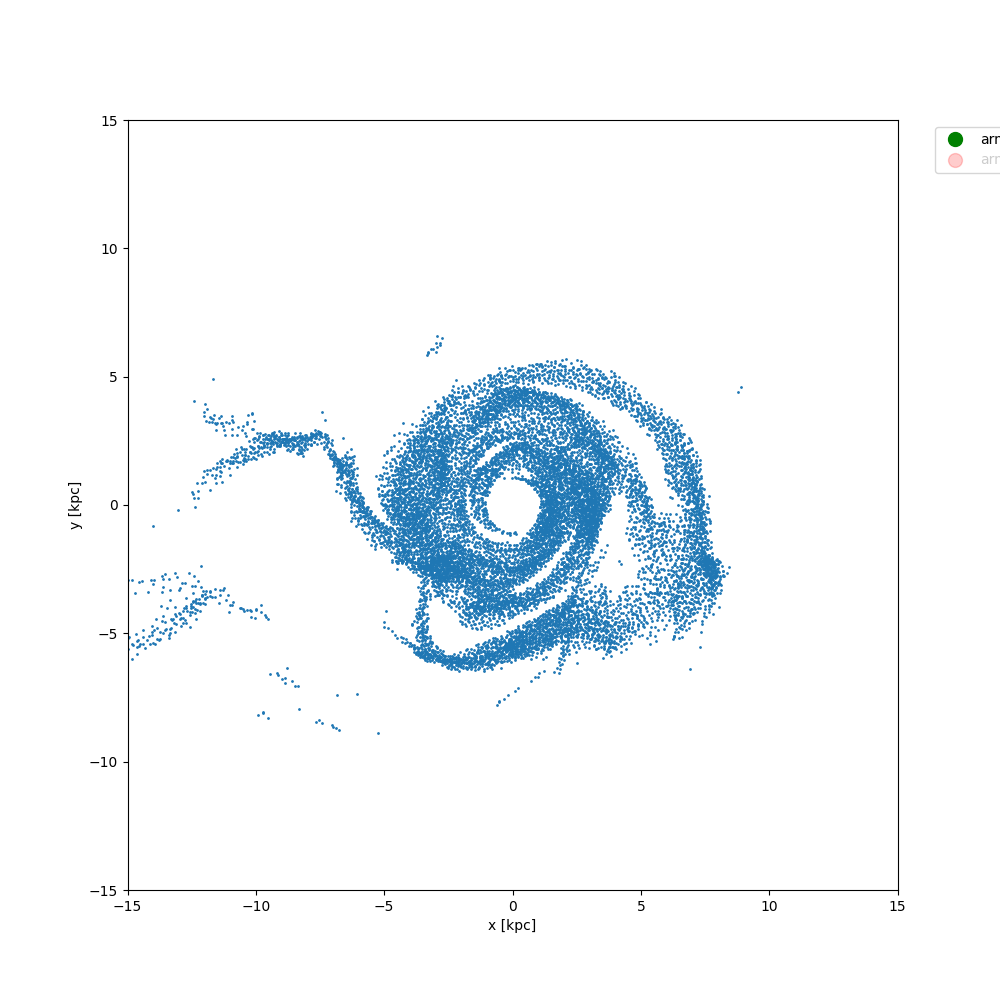

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(Xs,Ys,s=1,alpha=1)
R = 15
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

#ax.scatter(x_trace_arm1_rho,y_trace_arm1_rho,color='red',s=200,marker='*')

#for i in range(len(nums1_rho)):
#    ax.annotate(nums1_rho[i], (x_trace_arm1_rho[i], y_trace_arm1_rho[i]),fontsize=15)
klicker = clicker(ax, ["arm1",'arm2'], markers=["o","o"], colors = ['green','red'], markersize = 10)
ax.set_xlabel(r'x [kpc]')
ax.set_ylabel(r'y [kpc]')
ax.set_aspect('equal')

In [22]:
dict_pos = klicker.get_positions()
arm1 = pd.DataFrame({'x':dict_pos['arm1'][:,0],'y':dict_pos['arm1'][:,1]})
arm2 = pd.DataFrame({'x':dict_pos['arm2'][:,0],'y':dict_pos['arm2'][:,1]})

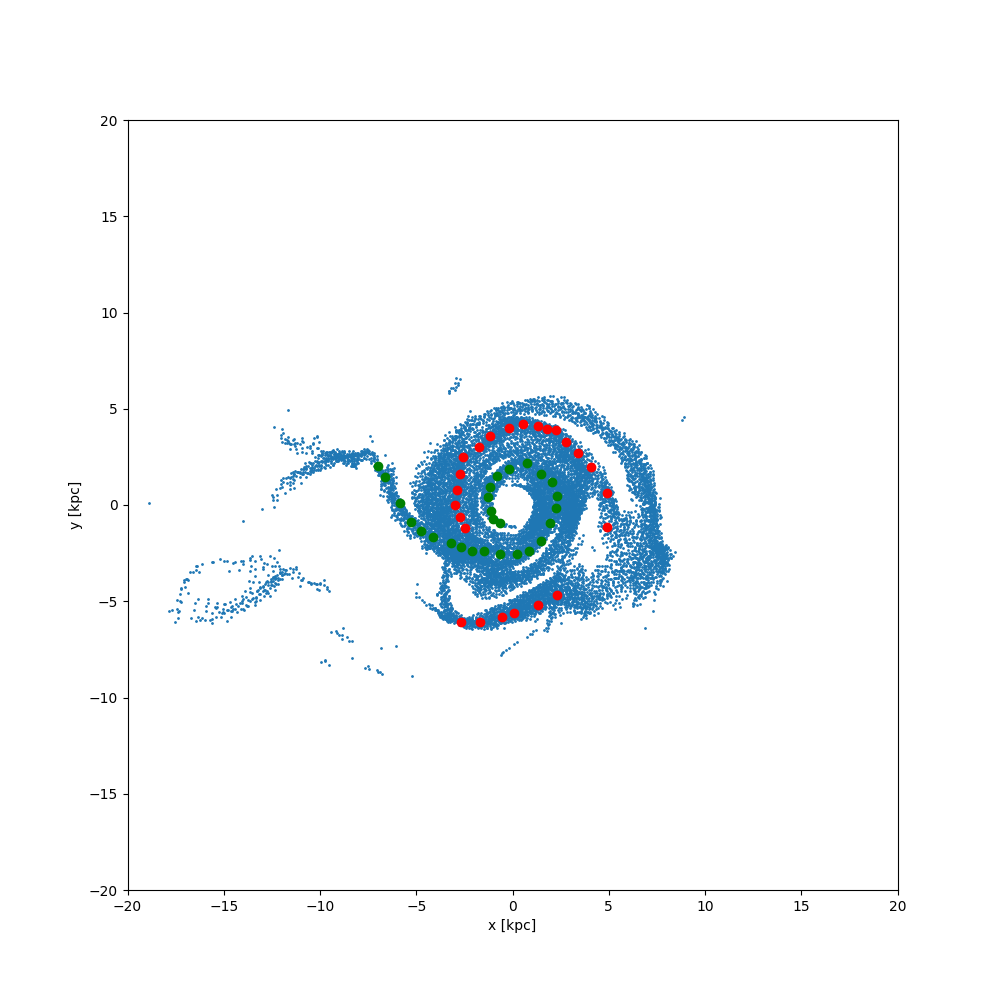

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(Xs,Ys,s=1,alpha=1)
ax.scatter(arm1.x, arm1.y, color = 'green')
ax.scatter(arm2.x, arm2.y, color = 'red')

R = 20
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_xlabel(r'x [kpc]')
ax.set_ylabel(r'y [kpc]')
ax.set_aspect('equal')

In [24]:
arm1.to_csv(f'DATA/processed/TracingPoints/arm_tracing_{id}_arm1_rho_dani.csv', index = False)
arm2.to_csv(f'DATA/processed/TracingPoints/arm_tracing_{id}_arm2_rho_dani.csv', index = False)